In [1]:
import csv
import pandas as pd

from os.path import join

DATA_DIR = '/home/qke100/su-data/academic-tree/'

## People DF

In [4]:
! head -6 /home/qke100/su-data/academic-tree/people.csv

"pid","firstname","middlename","lastname","degrees","location","locid","area","majorarea","award","hindex","orcid_id","s2id","homepage","addedby","dateadded"
"1","Stephen","V.","David","Ph.D.","Oregon Health and Science University","226","auditory system, attention","neuro,csd,bme","","30","0000-0003-4135-3104","2321659","http://hearingbrain.org/","david","2005-01-14 15:50:37"
"3","Jack","L.","Gallant","","University of California, Berkeley","312","Systems","neuro,psych","","NULL","NULL","NULL","http://gallantlab.org","david","2005-01-14 15:51:51"
"667145","Christian","T.","Totten","Ph.D.","University of Florida, Gainesville","380","Environmental Engineering","etree,environment","NULL","NULL","NULL","NULL","","pq","2016-07-23 11:14:13"
"5","Kendrick","Norris","Kay","Ph.D.","University of Minnesota, Twin Cities","406","visual system, fMRI, computational methods, neural network models","neuro","","NULL","","NULL","http://cvnlab.net","david","2005-01-15 18:20:41"
"6","Ryan","","Prenger","

In [5]:
def load_author_df():
    """"""
    result = []
    with open(join(DATA_DIR, 'people.csv')) as fin:
        reader = csv.reader(fin, delimiter=',')
        next(reader, None)
        for row in reader:
            result.append(list(row[:5]) + [row[8]] + [row[11]])
    col = ['pid', 'firstname', 'middlename', 'lastname', 'degrees', 'majorarea', 'orcid']
    df = pd.DataFrame(sorted(result, key=lambda x: int(x[0])), columns=col)
    for c in col[1:]:
        df[c] = df[c].apply(lambda x: '' if x == 'NULL' else x)
    return df

people_df = load_author_df()
people_df.shape

(760831, 7)

In [6]:
people_df.head()

,pid,firstname,middlename,lastname,degrees,majorarea,orcid
0,1,Stephen,V.,David,Ph.D.,"neuro,csd,bme",0000-0003-4135-3104
1,2,Benjamin,Y.,Hayden,,neuro,0000-0002-7678-4281
2,3,Jack,L.,Gallant,,"neuro,psych",
3,4,Benjamin,,Willmore,Ph.D.,neuro,
4,5,Kendrick,Norris,Kay,Ph.D.,neuro,


In [7]:
[(c, (people_df[c] == '').sum()) for c in people_df.columns]

[('pid', 0),
 ('firstname', 478),
 ('middlename', 352574),
 ('lastname', 897),
 ('degrees', 303948),
 ('majorarea', 1),
 ('orcid', 759414)]

In [8]:
[(c, people_df[c].isna().sum()) for c in people_df.columns]

[('pid', 0),
 ('firstname', 0),
 ('middlename', 0),
 ('lastname', 0),
 ('degrees', 0),
 ('majorarea', 0),
 ('orcid', 0)]

In [9]:
people_df.pid.nunique()

760829

In [10]:
people_df.pid.value_counts()

829309    2
825932    2
337569    1
733721    1
478591    1
         ..
752780    1
479576    1
184344    1
220516    1
485288    1
Name: pid, Length: 760829, dtype: int64

In [11]:
people_df[people_df.pid == '829309']

,pid,firstname,middlename,lastname,degrees,majorarea,orcid
760721,829309,Aart,Jan,Eeuwe,,plantbio,
760722,829309,Adam,H,Ridgewell,,neuro,


In [12]:
people_df[people_df.pid == '825932']

,pid,firstname,middlename,lastname,degrees,majorarea,orcid
760166,825932,Jeung-Yoon,(Elizabeth),Choi,,neuro,
760167,825932,Jeung-Yoon,(Elizabeth),Choi,,etree,


In [16]:
ds_people = people_df[
    (people_df.firstname != '')
    & (people_df.lastname != '')
    & (people_df.pid != '829309')
].drop_duplicates(subset=['pid', 'firstname', 'middlename', 'lastname']).copy().reset_index(drop=True)
ds_people.shape

(759676, 7)

In [17]:
ds_people[ds_people.pid == '825932']

,pid,firstname,middlename,lastname,degrees,majorarea,orcid
759025,825932,Jeung-Yoon,(Elizabeth),Choi,,neuro,


In [18]:
ds_people.at[759025, 'majorarea'] = 'neuro,etree' # combine the two major areas for 825932

In [19]:
ds_people[ds_people.pid == '825932']

,pid,firstname,middlename,lastname,degrees,majorarea,orcid
759025,825932,Jeung-Yoon,(Elizabeth),Choi,,"neuro,etree",


In [20]:
ds_people.pid.nunique()

759676

In [21]:
ds_people.pid.value_counts()

651454    1
765952    1
733721    1
478591    1
602727    1
         ..
672750    1
319178    1
526908    1
213794    1
485288    1
Name: pid, Length: 759676, dtype: int64

### ORCID

In [43]:
orcid_dict = {
    '000-0003-2721-3770': '0000-0003-2721-3770',
    '0000000246091337': '0000-0002-4609-1337',
    '0000-00019801-2963': '0000-0001-9801-2963',
    '00000003-2983-6330': '0000-0003-2983-6330',
    '0000000348394400': '0000-0003-4839-4400',
    '0000–0002–8587–4115': '0000-0002-8587-4115',
}

def clean_orcid(x):
    """"""
    if x == '':
        return x
    xs = x.replace('\u200b', '').strip(' ",')
    for s in ['https://orcid.org/', 'http://orcid.org/', 'orcid.org/']:
        if xs.startswith(s):
            xs = xs[len(s):].strip()
            break
    parts = xs.split('-')
    if len(xs) == 19 and len(parts) == 4 and all(len(e) == 4 for e in parts):
        return xs
    if xs in orcid_dict:
        return orcid_dict[xs]
    print('=====', xs, '=====')
    return ''

ds_people['orcid_norm'] = ds_people.orcid.apply(clean_orcid)

===== AGVG75 =====
===== A-8474-2013 =====
===== J-5755-2014 =====
===== https://www.ncbi.nlm.nih.gov/sites/myncbi/fletcher.white.1/bibliography/40234758/public/?sort=date&direction=descending =====
===== Katherine M. Mathis =====
===== <div itemscope itemtype="https://schema.org/Person"><a itemprop="sameAs" content="https://orcid.org/0000-0002-9254-5360" href="https://orcid.org/0000-0002-9254-5360" target="orcid.widget" rel="noopener noreferrer" style="vertical-align:top;"><img src="htt =====
===== SANTIAGOID =====
===== 0002-4068-1168 =====
===== B-5365-2009 =====
===== 0000-0001-8507-256 =====
===== C-4348-2013 =====
===== my-orcid =====
===== 0000-0001-6779-247 =====


In [45]:
(ds_people.orcid != '').sum(), (ds_people.orcid_norm != '').sum()

(1416, 1403)

### Gender

In [53]:
def norm_firstname(x):
    """"""
    xs = x.strip()
    parts = xs.split()
    if len(parts) == 1:
        return xs
    if parts[0] in {'Sir', 'Dr', 'Dr.'}:
        return ' '.join(parts[1:])
    return xs

ds_people['firstname_norm'] = ds_people.firstname.apply(norm_firstname)

In [54]:
pd.Series(ds_people['firstname_norm'].unique()).to_csv(
    'ORCID_career_flows/data_processing/BayesCCM/inference/at_first.csv', index=False, header=['First'])

In [ ]:
# run in the terminal
# cd ORCID_career_flows/data_processing/BayesCCM/inference/api
# python3
import cct

PATH_TO_CSV = '../at_first.csv'
PATH_TO_SAVE = PATH_TO_CSV.split('.csv')[0]+'_CC.csv'
data_with_cct = cct.evaluate_cct(PATH_TO_CSV, PATH_TO_SAVE)
data_with_cct.head(20)

In [55]:
first_cc = pd.read_csv('ORCID_career_flows/data_processing/BayesCCM/inference/at_first_CC.csv')
first_cc.shape

(93433, 2)

In [56]:
first_cc.sample(10)

,First,CulturalConsensus
22571,yichin,NaN
13918,gu,2.331997e-05
42422,soo-jung,NaN
83493,maria-ana,NaN
81521,enge,NaN
15579,vladímir,NaN
43672,hsueh-yun,NaN
66184,ezemenari,NaN
92312,obdulio,1.000000e-10
48621,zhongmou,NaN


<AxesSubplot:>

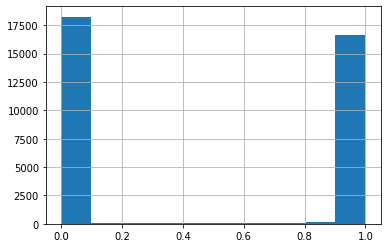

In [60]:
first_cc.CulturalConsensus.hist()

In [61]:
first_gender = {
    a: 'M' if b < .1 else 'F' for a, b in zip(first_cc.First, first_cc.CulturalConsensus)
    if pd.notna(b) and (b < .1 or b > .9)}
len(first_gender)

33370

In [62]:
ds_people['gender'] = ds_people.firstname_norm.apply(lambda x: first_gender.get(x.lower(), None))

In [65]:
ds_people.gender.notna().sum() / ds_people.shape[0]

0.889514740494632

In [66]:
ds_people.to_hdf('dataset/people_df.h5', key='df', mode='w')

/home/qke100/.local/lib/python3.6/site-packages/pandas/core/generic.py:2449: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['pid', 'firstname', 'middlename', 'lastname', 'degrees', 'majorarea',
       'orcid', 'orcid_norm', 'firstname_norm', 'gender'],
      dtype='object')]

  encoding=encoding,


In [67]:
ds_people.head()

,pid,firstname,middlename,lastname,degrees,majorarea,orcid,orcid_norm,firstname_norm,gender
0,1,Stephen,V.,David,Ph.D.,"neuro,csd,bme",0000-0003-4135-3104,0000-0003-4135-3104,Stephen,M
1,2,Benjamin,Y.,Hayden,,neuro,0000-0002-7678-4281,0000-0002-7678-4281,Benjamin,M
2,3,Jack,L.,Gallant,,"neuro,psych",,,Jack,M
3,4,Benjamin,,Willmore,Ph.D.,neuro,,,Benjamin,M
4,5,Kendrick,Norris,Kay,Ph.D.,neuro,,,Kendrick,M
